In [435]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [436]:
pattern = cv2.imread('data/trybik.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('data/trybiki2.jpg', cv2.IMREAD_GRAYSCALE)

In [438]:
def generalized_hough_transform(
        pattern: np.ndarray,
        image: np.ndarray,
        gradient_threshold: float = 0.5,
) -> np.ndarray:
    
    binarized = cv2.threshold(pattern, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    binarized = cv2.medianBlur(binarized, 5)
    contours, _ = cv2.findContours(cv2.bitwise_not(binarized), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    sobel_x = cv2.Sobel(pattern, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(pattern, cv2.CV_64F, 0, 1, ksize=5)

    gradient_direction_pattern = (np.rad2deg(np.arctan2(sobel_y, sobel_x)).astype(int)+180)%360

    momenta = cv2.moments(binarized, 1)
    x_mass_center = int(momenta['m10'] / momenta['m00'])
    y_mass_center = int(momenta['m01'] / momenta['m00'])

    Rtable = [[] for _ in range(360)]

    for point in contours[0]:
        x = point[0, 0] - x_mass_center
        y = point[0, 1] - y_mass_center
        Rtable[gradient_direction_pattern[point[0, 1], point[0, 0]]].append((np.sqrt(x*x + y*y), np.arctan2(y, x)))


    sobel_x_image = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y_image = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

    gradient_magnitude_image = np.sqrt(sobel_x_image ** 2 + sobel_y_image ** 2)
    gradient_direction_image = (np.rad2deg(np.arctan2(sobel_y_image, sobel_x_image)).astype(int)+180)%360

    hough = np.zeros(image.shape, dtype=np.uint8)

    for y, x in zip(*np.where(gradient_magnitude_image > gradient_threshold*np.max(gradient_magnitude_image))):
        for r, phi in Rtable[gradient_direction_image[y, x]]:
            try:
                hough[int(y - r*np.sin(phi)), int(x - r*np.cos(phi))] += 1
            except IndexError:
                pass

    return hough

In [439]:
hough = generalized_hough_transform(pattern, image)

(array([308], dtype=int64), array([98], dtype=int64))


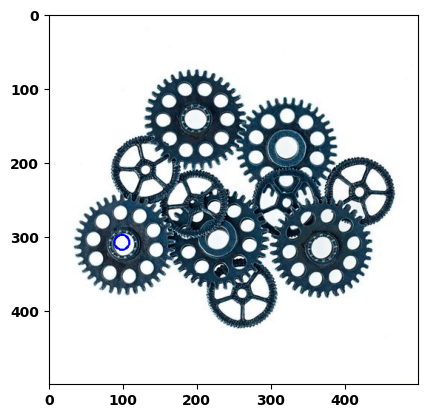

In [440]:
image = cv2.imread('data/trybiki2.jpg', cv2.IMREAD_COLOR)
M = np.where(hough.max() == hough)
for i in range(len(M[0])):
    image = cv2.circle(image, (M[1][i], M[0][i]), 10, (0, 0, 255), 2)
plt.imshow(image)  
plt.show()


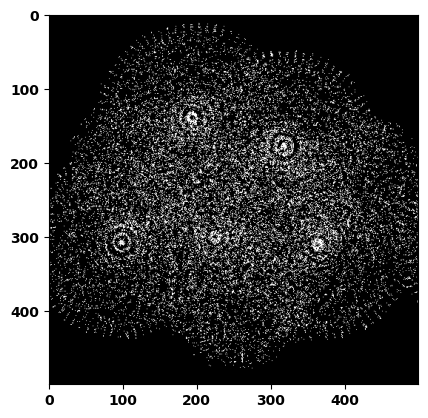

In [441]:
plt.imshow(255*hough/np.max(hough), cmap='gray')